In [27]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from tqdm import tqdm

## Simulating data

In [2]:
# Parameters
num_users = 10000
states = ['greeting', 'product_inquiry', 'purchase_decision', 'confirm_purchase', 'terminal']
actions = ['ask_preferences', 'recommend_product', 'show_discounts', 'confirm_purchase']

In [3]:
# Probabilities for transitions
state_transitions = {
    'greeting': {'product_inquiry': 0.8, 'terminal': 0.2},
    'product_inquiry': {'purchase_decision': 0.7, 'terminal': 0.3},
    'purchase_decision': {'confirm_purchase': 0.6, 'terminal': 0.4},
    'confirm_purchase': {'terminal': 1.0},
}

In [4]:
# Probabilities for actions per state
action_choices = {
    'greeting': ['ask_preferences', 'show_discounts'],
    'product_inquiry': ['recommend_product'],
    'purchase_decision': ['confirm_purchase'],
    'confirm_purchase': ['confirm_purchase'],
}

In [5]:
# Simulate sessions
data = []

for session_id in range(1, num_users + 1):
    state = 'greeting'
    timestamp = datetime(2024, 12, 5, 9, 0, 0) + timedelta(minutes=np.random.randint(0, 1440))  # Random start time
    converted = 0

    while state != 'terminal':
        action = np.random.choice(action_choices[state])  # Choose an action for the state
        next_states = list(state_transitions[state].keys())
        next_state_probs = list(state_transitions[state].values())
        next_state = np.random.choice(next_states, p=next_state_probs)  # Choose next state

        # Time lapse for transition
        time_lapse = np.random.randint(5, 30)
        timestamp += timedelta(seconds=time_lapse)

        # Determine conversion at 'confirm_purchase' state
        if state == 'confirm_purchase' and next_state == 'terminal':
            converted = np.random.choice([0, 1], p=[0.5, 0.5])  # 50% chance of purchase

        # Append the row
        data.append({
            'session_id': session_id,
            'timestamp': timestamp,
            'state': state,
            'action': action,
            'next_state': next_state,
            'time_lapse': time_lapse,
            'converted': converted
        })

        state = next_state  # Update to the next state

In [8]:
# Create the DataFrame
df = pd.DataFrame(data)

# Ensure 'converted' is consistent within a session
df['converted'] = df.groupby('session_id')['converted'].transform('max')

display(df.head(10))


,session_id,timestamp,state,action,next_state,time_lapse,converted
0,1,2024-12-05 11:07:17,greeting,show_discounts,product_inquiry,17,0
1,1,2024-12-05 11:07:37,product_inquiry,recommend_product,terminal,20,0
2,2,2024-12-06 05:17:29,greeting,show_discounts,terminal,29,0
3,3,2024-12-06 08:48:20,greeting,show_discounts,product_inquiry,20,1
4,3,2024-12-06 08:48:42,product_inquiry,recommend_product,purchase_decision,22,1
5,3,2024-12-06 08:49:07,purchase_decision,confirm_purchase,confirm_purchase,25,1
6,3,2024-12-06 08:49:20,confirm_purchase,confirm_purchase,terminal,13,1
7,4,2024-12-05 18:22:24,greeting,show_discounts,product_inquiry,24,0
8,4,2024-12-05 18:22:52,product_inquiry,recommend_product,terminal,28,0
9,5,2024-12-05 13:31:28,greeting,show_discounts,product_inquiry,28,0


In [9]:
# Sort by session_id and timestamp to ensure proper sequence
df = df.sort_values(by=['session_id', 'timestamp'])

# Add the next_state column
df['next_state'] = df.groupby('session_id')['state'].shift(-1)

# Fill NaN next_state for the last step in each session
df['next_state'] = df['next_state'].fillna('terminal')

# Add reward column (1 for purchase at the end of session, 0 otherwise)
df['reward'] = df.groupby('session_id')['converted'].transform('max')


In [10]:
df.head(10)

,session_id,timestamp,state,action,next_state,time_lapse,converted,reward
0,1,2024-12-05 11:07:17,greeting,show_discounts,product_inquiry,17,0,0
1,1,2024-12-05 11:07:37,product_inquiry,recommend_product,terminal,20,0,0
2,2,2024-12-06 05:17:29,greeting,show_discounts,terminal,29,0,0
3,3,2024-12-06 08:48:20,greeting,show_discounts,product_inquiry,20,1,1
4,3,2024-12-06 08:48:42,product_inquiry,recommend_product,purchase_decision,22,1,1
5,3,2024-12-06 08:49:07,purchase_decision,confirm_purchase,confirm_purchase,25,1,1
6,3,2024-12-06 08:49:20,confirm_purchase,confirm_purchase,terminal,13,1,1
7,4,2024-12-05 18:22:24,greeting,show_discounts,product_inquiry,24,0,0
8,4,2024-12-05 18:22:52,product_inquiry,recommend_product,terminal,28,0,0
9,5,2024-12-05 13:31:28,greeting,show_discounts,product_inquiry,28,0,0


## Implementing Q-learning

In [11]:
# Encode states and actions
unique_states = df['state'].unique()
unique_actions = df['action'].unique()

state_to_index = {state: idx for idx, state in enumerate(unique_states)}
action_to_index = {action: idx for idx, action in enumerate(unique_actions)}

num_states = len(unique_states)
num_actions = len(unique_actions)

In [21]:
# Initialize Q-table
Q_table = np.zeros((num_states, num_actions))
Q_table

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [22]:
unique_states

array(['greeting', 'product_inquiry', 'purchase_decision',
       'confirm_purchase'], dtype=object)

In [23]:
unique_actions

array(['show_discounts', 'recommend_product', 'confirm_purchase',
       'ask_preferences'], dtype=object)

In [24]:
alpha = 0.1    # Learning rate
gamma = 0.9    # Discount factor
epsilon = 0.2  # Exploration rate

In [29]:
num_episodes = 100

In [30]:
for episode in tqdm(range(num_episodes)):
    for session_id, session_data in df.groupby('session_id'):
        for idx, row in session_data.iterrows():
            state = state_to_index[row['state']]
            action = action_to_index[row['action']]
            
            # Handle next_state
            if row['next_state'] == 'terminal':
                next_state = None
                max_future_q = 0  # No future reward for terminal state
            else:
                next_state = state_to_index[row['next_state']]
                max_future_q = np.max(Q_table[next_state, :])
            
            # Reward
            reward = row['reward']
            
            # Update Q-value
            current_q = Q_table[state, action]
            Q_table[state, action] = current_q + alpha * (reward + gamma * max_future_q - current_q)

100%|██████████| 100/100 [09:22<00:00,  5.62s/it]


In [31]:
Q_table

array([[0.71855699, 0.        , 0.        , 0.67727574],
       [0.        , 0.55906513, 0.        , 0.        ],
       [0.        , 0.        , 0.53345576, 0.        ],
       [0.        , 0.        , 0.46919235, 0.        ]])

In [32]:
optimal_policy = {state: np.argmax(Q_table[state_to_index[state], :]) for state in unique_states}
optimal_policy

{'greeting': 0,
 'product_inquiry': 1,
 'purchase_decision': 2,
 'confirm_purchase': 2}

In [34]:
# Example mapping
state_to_index = {'greeting': 0, 'product_inquiry': 1, 'purchase_decision': 2, 'confirm_purchase': 3}
action_to_index = {'ask_preferences': 0, 'recommend_product': 1, 'show_discounts': 2, 'confirm_purchase': 3}

# Reverse mapping for output
index_to_action = {idx: action for action, idx in action_to_index.items()}
index_to_action

{0: 'ask_preferences',
 1: 'recommend_product',
 2: 'show_discounts',
 3: 'confirm_purchase'}

In [35]:
# Function to infer action
def infer_action(state, Q_table, epsilon=0.0):
    """
    Infer the best action for a given state using the Q-matrix.
    Args:
        state (str): Current state.
        Q_table (numpy array): Trained Q-matrix.
        epsilon (float): Exploration rate for random actions.
    Returns:
        str: Inferred action.
    """
    state_idx = state_to_index[state]
    
    if np.random.rand() < epsilon:  # Exploration
        action_idx = np.random.choice(Q_table.shape[1])
    else:  # Exploitation
        action_idx = np.argmax(Q_table[state_idx, :])
    
    return index_to_action[action_idx]

In [36]:
# Example usage for a new state
new_state = 'product_inquiry'
best_action = infer_action(new_state, Q_table)
print(f"For state '{new_state}', the recommended action is '{best_action}'.")


For state 'product_inquiry', the recommended action is 'recommend_product'.


In [37]:
def simulate_session(start_state, Q_table):
    """
    Simulate a chatbot session using the Q-matrix.
    Args:
        start_state (str): Initial state.
        Q_table (numpy array): Trained Q-matrix.
    Returns:
        list of tuples: Sequence of (state, action).
    """
    session_sequence = []
    state = start_state
    
    while state != 'terminal':
        action = infer_action(state, Q_table)
        session_sequence.append((state, action))
        
        # Simulate state transition based on action (can use real transition rules)
        next_states = list(state_transitions[state].keys())
        next_state_probs = list(state_transitions[state].values())
        state = np.random.choice(next_states, p=next_state_probs)
    
    return session_sequence

In [54]:
# Example session simulation
simulated_session = simulate_session('greeting', Q_table)
print(simulated_session)

[('greeting', 'ask_preferences'), ('product_inquiry', 'recommend_product'), ('purchase_decision', 'show_discounts')]


In [55]:
Q_table

array([[0.71855699, 0.        , 0.        , 0.67727574],
       [0.        , 0.55906513, 0.        , 0.        ],
       [0.        , 0.        , 0.53345576, 0.        ],
       [0.        , 0.        , 0.46919235, 0.        ]])

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

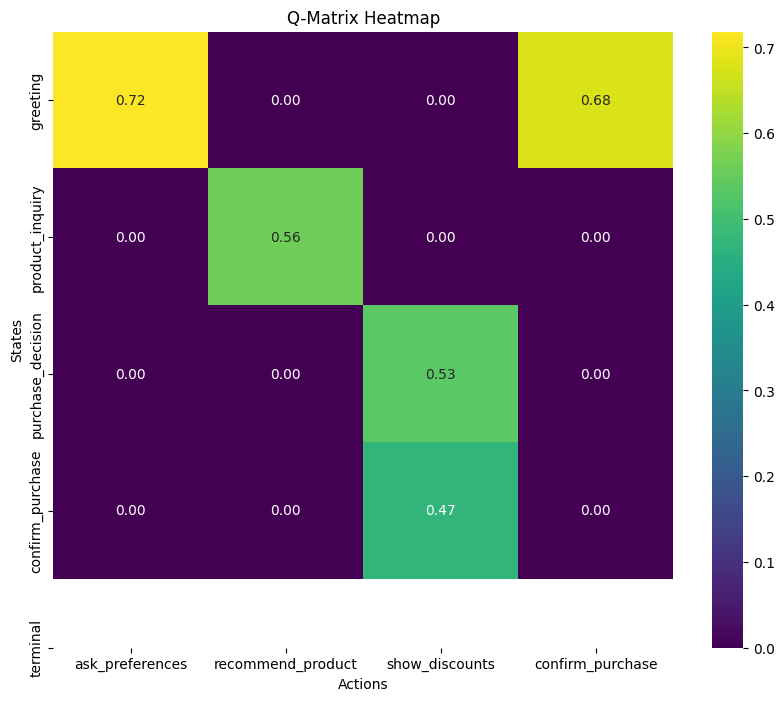

In [57]:
# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(Q_table, annot=True, fmt=".2f", cmap="viridis", xticklabels=actions, yticklabels=states)
plt.title("Q-Matrix Heatmap")
plt.xlabel("Actions")
plt.ylabel("States")
plt.show()
